In [1]:
import sys
import os.path
import numpy as np
import tensorflow as tf
import keras
import xarray as xr
import sys
sys.argv = sys.argv[:1]
import tensorflow as tf
from layers.GradientHighwayUnit import GHU as ghu
from layers.CausalLSTMCell import CausalLSTMCell as cslstm
from parflow_nn.preprocess_PF import create_feature_or_target_da

Using TensorFlow backend.


In [2]:
import os.path
import time
import numpy as np
import tensorflow as tf
import sys
import random
from nets import models_factory
from data_provider import datasets_factory
from utils import preprocess
from utils import metrics

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Normalization
def normalize_feature_da(feature_da, feature_names=None):
    """Normalize feature arrays, and optionally target array
    Args:
        feature_da: feature Dataset
        feature_names: Feature name strings
    Returns:
        da: Normalized DataArray
    """
    if feature_names is not None: # static inputs
        con_stats_norm = []
        for feati in feature_da:
            if len(np.unique(feati)) == 1:
                con_stats_norm.append(feati)
            else:
                meani = np.ma.mean(feati, axis = (2, 3))
                stdi = np.ma.std(feati, axis = (2, 3))
                meani[stdi == 0] = 0
                stdi[stdi == 0] = 1
                #broadcast back stdi
                stdi_broadcast = np.tile(stdi, (1, feati.shape[2], feati.shape[3], 1))
                stdi_broadcast = np.swapaxes(stdi_broadcast, 2, 3)
                stdi_broadcast = np.swapaxes(stdi_broadcast, 1, 2)
                #broadcast back meani
                meani_broadcast = np.tile(meani, (1, feati.shape[2], feati.shape[3], 1))
                meani_broadcast = np.swapaxes(meani_broadcast, 2, 3)
                meani_broadcast = np.swapaxes(meani_broadcast, 1, 2)
                feati_norm = (feati - meani_broadcast) / stdi_broadcast
                con_stats_norm.append(feati_norm)
        return con_stats_norm
    else: # forcing inputs and target
        forcing_mean = np.ma.mean(feature_da, axis = (0, 1, 2, 3))
        forcing_std = np.ma.std(feature_da, axis = (0, 1, 2, 3))
        forcing_mean[forcing_std == 0] = 0
        forcing_std[forcing_std == 0] = 1
        #broadcast back
        mean_broadcast = np.tile(forcing_mean, (1, feature_da.shape[1], feature_da.shape[2],
                                feature_da.shape[3], 1))
        std_broadcast = np.tile(forcing_std, (1, feature_da.shape[1], feature_da.shape[2],
                                feature_da.shape[3], 1))
        return (feature_da - mean_broadcast) / std_broadcast


In [5]:
# -----------------------------------------------------------------------------
FLAGS = tf.compat.v1.app.flags.FLAGS

# model
tf.compat.v1.app.flags.DEFINE_string('model_name', 'predrnn_pp',
                           'The name of the architecture.')
"""
tf.compat.v1.app.flags.DEFINE_string('pretrained_model', '/glade/scratch/hoangtran/predrnn_pretrained/',
                           'file of a pretrained model to initialize from.')
tf.compat.v1.app.flags.DEFINE_string('pretrained_model_meta', '/glade/scratch/hoangtran/predrnn_pretrained/model1.ckpt-300.meta',
                           'file of a pretrained model metadata file to initialize from.')
"""
tf.compat.v1.app.flags.DEFINE_string('pretrained_model', '',
                           'file of a pretrained model to initialize from.')
tf.compat.v1.app.flags.DEFINE_string('pretrained_model_meta', '',
                           'file of a pretrained model metadata file to initialize from.')
tf.compat.v1.app.flags.DEFINE_integer('seq_length', 24*30,
                            'total input and output length.')
tf.compat.v1.app.flags.DEFINE_integer('img_width', 41,
                            'input image width.')
tf.compat.v1.app.flags.DEFINE_integer('img_channel', 8,
                            'number of image channel.')
tf.compat.v1.app.flags.DEFINE_integer('target_channel', 123,
                            'number of target channel.')
tf.compat.v1.app.flags.DEFINE_integer('stride', 1,
                            'stride of a convlstm layer.')
tf.compat.v1.app.flags.DEFINE_integer('filter_size', 5,
                            'filter of a convlstm layer.')
tf.compat.v1.app.flags.DEFINE_string('num_hidden', '32,64,64,64,128',
                           'COMMA separated number of units in a convlstm layer.')
tf.compat.v1.app.flags.DEFINE_integer('patch_size', 1,
                            'patch size on one dimension.')
tf.compat.v1.app.flags.DEFINE_boolean('layer_norm', True,
                            'whether to apply tensor layer norm.')
# optimization
tf.compat.v1.app.flags.DEFINE_float('lr', 0.001,
                          'base learning rate.')
tf.compat.v1.app.flags.DEFINE_boolean('reverse_input', True,
                            'whether to reverse the input frames while training.')
tf.compat.v1.app.flags.DEFINE_integer('batch_size', 12,
                            'batch size for training.')
tf.compat.v1.app.flags.DEFINE_integer('max_iterations', 300,
                            'max num of steps.')
tf.compat.v1.app.flags.DEFINE_integer('display_interval', 1,
                            'number of iters showing training loss.')
tf.compat.v1.app.flags.DEFINE_integer('test_interval', 2000,
                            'number of iters for test.')
tf.compat.v1.app.flags.DEFINE_integer('snapshot_interval', 10000,
                            'number of iters saving models.')


In [6]:
class Model(object):
    def __init__(self):
        # inputs
        self.x = tf.compat.v1.placeholder(tf.float32,
                                [FLAGS.batch_size,
                                 FLAGS.seq_length,
                                 FLAGS.img_width/FLAGS.patch_size,
                                 FLAGS.img_width/FLAGS.patch_size,
                                 FLAGS.patch_size*FLAGS.patch_size*FLAGS.img_channel])
        
        # targets
        self.y = tf.compat.v1.placeholder(tf.float32,
                                [FLAGS.batch_size,
                                 FLAGS.seq_length,
                                 FLAGS.img_width/FLAGS.patch_size,
                                 FLAGS.img_width/FLAGS.patch_size,
                                 FLAGS.patch_size*FLAGS.patch_size*FLAGS.target_channel])


        grads = []
        loss_train = []
        self.pred_seq = []
        self.tf_lr = tf.compat.v1.placeholder(tf.float32, shape=[])
        num_hidden = [int(x) for x in FLAGS.num_hidden.split(',')]
        print(num_hidden)
        num_layers = len(num_hidden)
        with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope()):
            # define a model
            output_list = models_factory.construct_model(
                FLAGS.model_name, self.x, self.y, 
                num_layers, num_hidden,
                FLAGS.filter_size, FLAGS.stride,
                FLAGS.seq_length,
                FLAGS.layer_norm)
            gen_ims = output_list[0]
            loss = output_list[1]
            pred_ims = gen_ims
            self.loss_train = loss / FLAGS.batch_size
            # gradients
            all_params = tf.compat.v1.trainable_variables()
            grads.append(tf.gradients(loss, all_params))
            self.pred_seq.append(pred_ims)
        
        self.train_op = tf.compat.v1.train.RMSPropOptimizer(FLAGS.lr).minimize(loss)

        # session
        variables = tf.compat.v1.global_variables()
        self.saver = tf.compat.v1.train.Saver(variables, save_relative_paths=True)
        init = tf.compat.v1.global_variables_initializer()
        configProt = tf.compat.v1.ConfigProto()
        configProt.gpu_options.allow_growth = True
        configProt.allow_soft_placement = True
        self.sess = tf.compat.v1.Session(config = configProt)
        self.sess.run(init)
        if FLAGS.pretrained_model:
            self.saver = tf.compat.v1.train.import_meta_graph(FLAGS.pretrained_model_meta)
            self.saver.restore(self.sess, tf.compat.v1.train.latest_checkpoint(FLAGS.pretrained_model))

    def train(self, inputs, targets, lr):
        feed_dict = {self.x: inputs}
        feed_dict.update({self.y: targets})
        feed_dict.update({self.tf_lr: lr})
        loss, _ = self.sess.run((self.loss_train, self.train_op), feed_dict)
        return loss

    def test(self, inputs):
        feed_dict = {self.x: inputs}
        targets = np.ones((FLAGS.batch_size,
                             FLAGS.seq_length,
                             int(FLAGS.img_width/FLAGS.patch_size),
                             int(FLAGS.img_width/FLAGS.patch_size),
                             int(FLAGS.patch_size*FLAGS.patch_size*FLAGS.target_channel)))
        feed_dict.update({self.y: targets})
        gen_ims = self.sess.run(self.pred_seq, feed_dict)
        return gen_ims

    def save(self, itr):
        checkpoint_path = os.path.join(FLAGS.save_dir, 'model1.ckpt')
        self.saver.save(self.sess, checkpoint_path, global_step=itr)
        print('saved to ' + FLAGS.save_dir)


In [7]:
def reshape_patch(img_tensor, patch_size):
    assert 5 == img_tensor.ndim
    batch_size = np.shape(img_tensor)[0]
    seq_length = np.shape(img_tensor)[1]
    img_height = np.shape(img_tensor)[2]
    img_width = np.shape(img_tensor)[3]
    num_channels = np.shape(img_tensor)[4]
    a = np.reshape(img_tensor, [batch_size, seq_length,
                                int(img_height/patch_size), patch_size,
                                int(img_width/patch_size), patch_size,
                                num_channels])
    b = np.transpose(a, [0,1,2,4,3,5,6])
    patch_tensor = np.reshape(b, [batch_size, seq_length,
                                  int(img_height/patch_size),
                                  int(img_width/patch_size),
                                  patch_size*patch_size*num_channels])
    return patch_tensor


In [8]:
run_name, out_dir, is_clm = 'washita_clm', '/glade/scratch/hoangtran/ParFlow-NN/nc_files', True

static_file = os.path.join(out_dir, f'{run_name}_static.nc')
forcing_file = os.path.join(out_dir, f'{run_name}_forcings.nc')
target_satur_file = os.path.join(out_dir, f'{run_name}_satur.nc')
target_press_file = os.path.join(out_dir, f'{run_name}_press.nc')

if is_clm:
    target_clm_file = os.path.join(out_dir, f'{run_name}_clm.nc')


In [9]:
# Forcing data
forcing_input = xr.open_dataset(forcing_file)

forcing_feature_da, forcing_feature_names = create_feature_or_target_da(
    forcing_input,
    ['forcings'],
    0,
    'feature',
    flx_same_dt=True
)

# Add channel dimension
if is_clm:
    forcing_feature_da = forcing_feature_da.data[:]
    forcing_feature_da = np.swapaxes(forcing_feature_da, 1, 2)
    forcing_feature_da = np.swapaxes(forcing_feature_da, 2, 3)
    forcing_feature_da = np.repeat(forcing_feature_da,
                           repeats=[2] + [1] * (forcing_feature_da.shape[0] - 1),
                           axis=0)  # duplicate the first row
    forcing_feature_da = forcing_feature_da[np.newaxis, ...]
else:
    forcing_feature_da = forcing_feature_da.data[:, 0, :, :]
    forcing_feature_da = forcing_feature_da[..., np.newaxis]
    forcing_feature_da = forcing_feature_da[np.newaxis, ...]


In [10]:
# Target outputs
target_press_input_xr = xr.open_dataset(target_press_file)
target_satur_input_xr = xr.open_dataset(target_satur_file)
if is_clm:
    target_clm_input_xr = xr.open_dataset(target_clm_file)
    target_clm = np.repeat(target_clm_input_xr.clm,
                           repeats=[2]+[1]*(target_clm_input_xr.clm.shape[0] - 1),
                           axis=0) #duplicate the first row
    target_da = np.concatenate([target_press_input_xr.press,
                        target_satur_input_xr.satur,
                        target_clm], axis = 1)
    target_da = target_da[np.newaxis, ...]
else:
    target_dataset = target_press_input_xr.merge(target_satur_input_xr)
    target_da, target_names = create_feature_or_target_da(
        target_dataset,
        ['press', 'satur'],
        0,
        'target',
        1,
        flx_same_dt=True
    )

    target_da = target_da.data[np.newaxis, ...]

target_da = np.swapaxes(target_da, 2, 3)
target_da = np.swapaxes(target_da, 3, 4)


In [42]:
list_days = np.arange(0, 365, 30)
forcings = []
targets = []
for ii,timei in enumerate(list_days[:-1]):
    forcings.append(forcing_feature_da[0, 24*timei: 24*list_days[ii + 1], :, :, :])
    targets.append(target_da[0, 24*timei: 24*list_days[ii + 1], :, :, :])

In [43]:
forcing_feature_train = np.stack(forcings)
target_train = np.stack(targets)

(12, 720, 41, 41, 8)
(12, 720, 41, 41, 123)


In [ ]:
#Normalization
forcing_norm_train = normalize_feature_da(forcing_feature_train)
target_norm_train = normalize_feature_da(target_train)

In [13]:
tf.compat.v1.disable_eager_execution()

In [14]:
t0 = time.time()
model = Model()
t1 = time.time()

print('time to load model: '+str(t1-t0))

lr = FLAGS.lr

delta = 0.00002
base = 0.99998
eta = 1

ims = reshape_patch(forcing_norm_train, FLAGS.patch_size)
tars = reshape_patch(target_norm_train, FLAGS.patch_size)

[32, 64, 64, 64, 128]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from /glade/scratch/hoangtran/predrnn_pretrained/model1.ckpt-300
time to load model: 240.85238933563232


In [28]:
for itr in range(1, 300 + 1):
    lr = 1e-8
    if itr < 50000:
        eta -= delta
    else:
        eta = 0.0
    t0 = time.time()
    cost = model.train(ims, tars, lr)
    if FLAGS.reverse_input:
        ims_rev = ims[:, ::-1]
        tars_rev = tars[:, ::-1]
        cost += model.train(ims_rev, tars_rev, lr)
        cost = cost/2
    t1 = time.time()
    print(itr, t1 - t0, cost)


1 2.2616546154022217 1370.22900390625
2 2.081730604171753 1443.024169921875
3 2.0816195011138916 1466.164306640625
4 2.08854603767395 1381.9403076171875
5 2.085062265396118 1310.8868408203125
6 2.066699743270874 1265.705078125
7 2.1191954612731934 1317.6865234375
8 2.119295120239258 1313.675048828125
9 2.0791525840759277 1358.75927734375
10 2.0350399017333984 1408.378173828125
11 2.048428535461426 1494.7447509765625
12 2.073413610458374 1484.4334716796875
13 2.156013250350952 1420.2679443359375
14 2.1786749362945557 1471.09130859375
15 2.1263773441314697 1555.0968017578125
16 2.0935139656066895 1484.10791015625
17 2.1002302169799805 1342.861083984375
18 2.091693639755249 1330.267822265625
19 2.1066792011260986 1280.0146484375
20 2.1042916774749756 1339.222900390625
21 2.1001901626586914 1451.01708984375
22 2.091064691543579 1555.8828125
23 2.1087427139282227 2143.19580078125
24 2.110881805419922 2911.47705078125
25 2.133070230484009 6034.869140625
26 2.0782241821289062 1754.27612304687

210 2.144477367401123 1364.714599609375
211 2.1526317596435547 1102.0029296875
212 2.221179723739624 1099.7763671875
213 2.234931468963623 1040.44287109375
214 2.209791421890259 1086.217529296875
215 2.07952618598938 1105.560546875
216 2.101168394088745 1090.188232421875
217 2.106715440750122 1215.616455078125
218 2.1201932430267334 1267.19140625
219 2.104217052459717 1373.70361328125
220 2.126230478286743 1421.93505859375
221 2.098787546157837 1273.60791015625
222 2.1055490970611572 1266.34814453125
223 2.101076126098633 1159.164794921875
224 2.103627920150757 1205.02685546875
225 2.1903624534606934 1242.150390625
226 2.2011306285858154 1266.437255859375
227 2.2492172718048096 1246.9920654296875
228 2.253852128982544 1267.1064453125
229 2.2798449993133545 1283.4554443359375
230 2.2326018810272217 1294.89599609375
231 2.214569568634033 1269.9033203125
232 2.2988791465759277 1238.603759765625
233 2.307596445083618 1304.5302734375
234 2.17352032661438 1300.238525390625
235 2.284623146057

In [29]:
#tf.compat.v1.app.flags.DEFINE_string('save_dir','/glade/scratch/hoangtran/predrnn_pretrained/',
#                            'save_dir')
model.save(300)

saved to /glade/scratch/hoangtran/predrnn_pretrained/


In [30]:
forcing_feature_test = forcing_feature_da[:, 24:48, :, :, :]
target_test = target_da[:, 24:48, :, :, :]
#Normalization
forcing_norm_test = normalize_feature_da(forcing_feature_test)
target_norm_test = normalize_feature_da(target_test)
ims_test = reshape_patch(forcing_norm_test, FLAGS.patch_size)
tars_test = reshape_patch(target_norm_test, FLAGS.patch_size)

In [31]:
t0 = time.time()
predict = model.test(ims_test)
t1 = time.time()
print('predict time: '+str(t1-t0))

predict time: 0.3572838306427002


In [32]:
# De-normalization
target_mean = np.ma.mean(target_test, axis = (0, 1, 2, 3))
target_std = np.ma.std(target_test, axis = (0, 1, 2, 3))
#broadcast back
target_mean_broadcast = np.tile(target_mean, (1, target_test.shape[1], target_test.shape[2],
                                target_test.shape[3], 1))
target_std_broadcast = np.tile(target_std, (1, target_test.shape[1], target_test.shape[2],
                            target_test.shape[3], 1))

result_denorm = (predict[0] * target_std_broadcast[:, 1:, :, :, :]) + target_mean_broadcast[:, 1:, :, :, :]

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

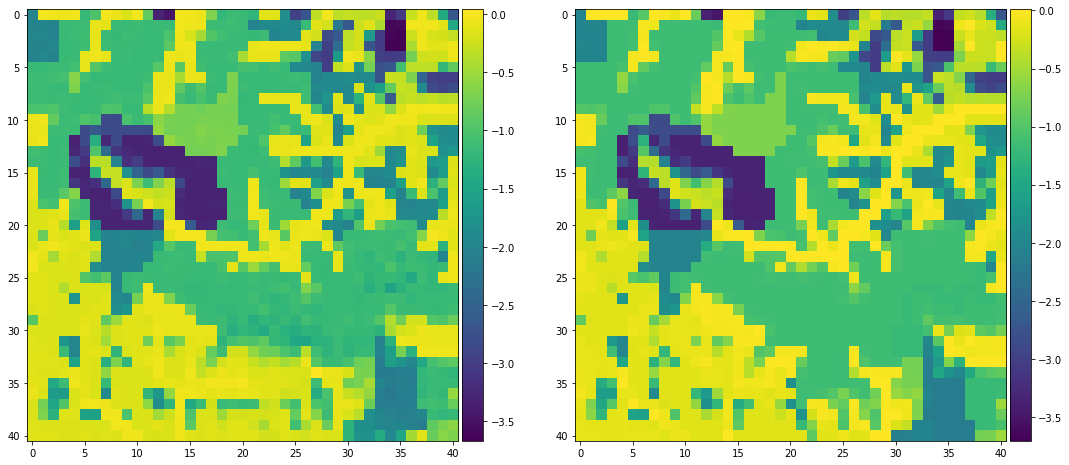

In [34]:
fig, axs = plt.subplots(1,2, figsize = (18, 18))

ax0 = axs[0]
im0 = ax0.imshow(result_denorm[0, 20, :, :, 49])
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax1 = axs[1]
im1 = ax1.imshow(target_test[0, 21, :, :, 49])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im1, cax = cax, orientation = 'vertical')

plt.show()

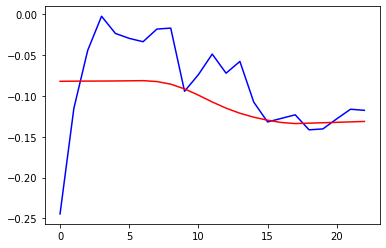

In [38]:
plt.plot(result_denorm[0, :, 14, 36, 49], 'b')
plt.plot(target_test[0, 1:, 14, 36, 49], 'r')
plt.show()